In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

import inspect

Using TensorFlow backend.


In [2]:
#Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{1-f(x_{T,i},\theta')}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model

First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the original Gaussian Notebook.

We will now parametrize our network by giving it $\mu$ and $\sigma$ values in addition to $X_i\sim\mathcal{N}(\mu, \sigma)$.

First we uniformly sample $\mu$ and $\sigma$ values in some range

In [3]:
mu_min = -2
mu_max = 2

sigma_min = 0.5
sigma_max = 4.5

We then sample from normal distributions with these $\mu$ and $\sigma$ values.

Please note that the samples in X0 are not paired with $\mu=0, \sigma = 1$ as this would make the task trivial. 

Instead it is paired with the $\mu, \sigma$ values uniformly sampled in the specified range [$\mu_{min}, \mu_{max}$] and [$\sigma_{min}, \sigma_{max}$].

For every value of $\mu$ in mu_values and every value of $\sigma$ in sigma_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ and $\sigma$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

## Build and Train DCTR model

In [4]:
# Either load or train DCTR


def make_dctr(load=False, n_data_points=10**7):
    if load:
        json_file = open('2d_gaussian_dctr_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        dctr_model = keras.models.model_from_json(loaded_model_json)
        # load weights into new model
        dctr_model.load_weights("2d_gaussian_dctr_model.h5")
        print("Loaded model from disk")
    else:
        # Generate training & validation data
        mu_values = np.random.uniform(mu_min, mu_max, n_data_points)
        sigma_values = np.random.uniform(sigma_min, sigma_max, n_data_points)

        X0 = [(np.random.normal(0, 1), mu_values[i], sigma_values[i])
              for i in range(n_data_points)]  # Note the zero in normal(0, 1)
        X1 = [(np.random.normal(mu_values[i], sigma_values[i]), mu_values[i],
               sigma_values[i]) for i in range(n_data_points)]

        Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
        Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

        X = np.concatenate((X0, X1))
        Y = np.concatenate((Y0, Y1))

        X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                            Y,
                                                            test_size=0.5)

        # Build Model
        inputs = Input((3, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(2, activation='softmax')(hidden_layer_3)

        dctr_model = Model(inputs=inputs, outputs=outputs)
        dctr_model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

        # Train Model
        earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
        dctr_model.fit(X_train,
                       Y_train,
                       epochs=200,
                       batch_size=10000,
                       validation_data=(X_test, Y_test),
                       callbacks=[earlystopping])

    return dctr_model

### Loading Model

In [5]:
dctr_model = make_dctr(load=True)









Loaded model from disk


## Defining reweighting functions

For a fully trained DCTR $f(x, \theta)$, the reweighting function is: $w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$.

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

The expression for the analytical reweighting function is : $w(x_T, \mu, \sigma) = \frac{\sigma_0}{\sigma}\exp{(-((\frac{x_T-\mu}{\sigma})^2-(\frac{x_T-\mu_0}{\sigma_0})^2)/2)}$.

In [6]:
theta0_param = (0, 1)


# from NN (DCTR)
def reweight(events, param):

    # creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=(events.shape[0], 2)) * param
    # combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)
    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events, param, param0=theta0_param):
    weights = (param0[1] / param[1]) * K.exp(-0.5 * (
        ((events - param[0]) / param[1])**2 -
        ((events - param0[0]) / param0[1])**2))
    return weights

## Validate DCTR for any $\mu$ and $\sigma$

In [7]:
mu1 = 1
sigma1 = 1.5
assert mu1 >= mu_min and mu1 <= mu_max  # choose mu1 in valid range
assert sigma1 >= sigma_min and sigma1 <= sigma_max  # choose mu1 in valid range
X0_val = np.random.normal(0, 1, 10**6)
X1_val = np.random.normal(mu1, sigma1, 10**6)

In [8]:
weights = reweight(
    K.expand_dims(tf.convert_to_tensor(X0_val, dtype=tf.float32)),
    np.array([mu1, sigma1]))
analytical_weights = analytical_reweight(X0_val, np.array([mu1, sigma1]))
weights = K.eval(weights)
analytical_weights = K.eval(analytical_weights)

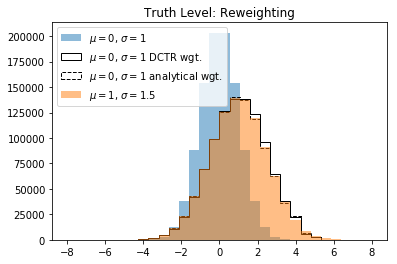

In [9]:
bins = np.linspace(-8, 8, 31)
plt.hist(X0_val, bins=bins, alpha=0.5, label=r'$\mu=0$, $\sigma=1$')
plt.hist(X0_val,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ DCTR wgt.',
         weights=weights,
         histtype='step',
         color='k')
plt.hist(X0_val,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ analytical wgt.',
         weights=analytical_weights,
         histtype='step',
         linestyle='--',
         color='k')
plt.hist(X1_val,
         bins=bins,
         alpha=0.5,
         label=r'$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
plt.legend()
plt.title("Truth Level: Reweighting")
plt.show()

## Saving Model

In [10]:
'''
model_json = dctr_model.to_json()
with open("2d_gaussian_dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("2d_gaussian_dctr_model.h5")
print("Saved model to disk")
'''

'\nmodel_json = dctr_model.to_json()\nwith open("2d_gaussian_dctr_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\ndctr_model.save_weights("2d_gaussian_dctr_model.h5")\nprint("Saved model to disk")\n'

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

In [11]:
N = 10**6
theta0_param = (
    0, 1
)  # this is the simulation ... N.B. this notation is reversed from above!
theta1_param = (1, 1.5)  # this is the data (the target)

theta0 = np.random.normal(theta0_param[0], theta0_param[1], N)
theta1 = np.random.normal(theta1_param[0], theta1_param[1], N)
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0, theta1])
yvals = np.concatenate([labels0, labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

## Fitting Model

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Cross Section for $\mu$

In [12]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000


def my_loss_wrapper(inputs,
                    val=0.,
                    reweight_analytically=False,
                    MSE_loss=True):
    x = inputs
    x = K.gather(x, np.arange(batch_size))

    theta_prime = [val, theta1_param[1]]  # fixed theta_sigma = sigma_truth

    if reweight_analytically:
        # analytical reweight
        weights = analytical_reweight(events=x, param=theta_prime)
    else:
        # NN (DCTR) reweight
        weights = reweight(events=x, param=theta_prime)

    def my_loss(y_true, y_pred):
        if MSE_loss:
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        else:
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))

        return K.mean(t_loss)

    return my_loss


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [13]:
thetas = np.linspace(-2, 2, 17)
lvals = []
vlvals = []

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper(myinputs, theta),
                  metrics=['accuracy'])
    model.fit(np.array(X_train),
              y_train,
              epochs=100,
              batch_size=1000,
              validation_data=(np.array(X_test), y_test),
              verbose=1,
              callbacks=[earlystopping])
    lvals += [np.min(model.history.history['loss'])]
    vlvals += [np.min(model.history.history['val_loss'])]
    print(lvals)
    print
    pass
print(lvals)

testing theta = : -2.0

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.1155 - acc: 0.5775 - val_loss: 0.1138 - val_acc: 0.5734
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1139 - acc: 0.5753 - val_loss: 0.1138 - val_acc: 0.5814
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1139 - acc: 0.5759 - val_loss: 0.1138 - val_acc: 0.5726
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1139 - acc: 0.5760 - val_loss: 0.1138 - val_acc: 0.5776
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1139 - acc: 0.5763 - val_loss: 0.1138 - val_acc: 0.5760
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1139 - acc: 0.5759 - val_loss: 0.113

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1556 - acc: 0.6127 - val_loss: 0.1555 - val_acc: 0.6112
[0.11389913830906152, 0.12697613140940667, 0.14077998942136766, 0.1556224104911089]
testing theta = : -1.0
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1707 - acc: 0.6260 - val_loss: 0.1706 - val_acc: 0.6264
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1707 - acc: 0.6257 - val_loss: 0.1706 - val_acc: 0.6278
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1707 - acc: 0.6259 - val_loss: 0.1706 - val_acc: 0.6274
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1707 - acc: 0.6259 - val_loss: 0.1706 - val_acc: 0.6261
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1707 - acc: 0.6257 - val_loss: 0.1706 - val_acc: 0.6267
Epoch

Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2262 - acc: 0.6629 - val_loss: 0.2260 - val_acc: 0.6634
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2262 - acc: 0.6630 - val_loss: 0.2260 - val_acc: 0.6607
[0.11389913830906152, 0.12697613140940667, 0.14077998942136766, 0.1556224104911089, 0.17069610522687434, 0.18587440206110478, 0.2004408008903265, 0.21366085907816887, 0.22617429941892625]
testing theta = : 0.25
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2364 - acc: 0.6681 - val_loss: 0.2361 - val_acc: 0.6667
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2364 - acc: 0.6675 - val_loss: 0.2361 - val_acc: 0.6690
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2364 - acc: 0.6682 - val_loss: 0.2363 - val_acc: 0.6678
Epoch 4/100
1000000/1000000 [=

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2482 - acc: 0.3384 - val_loss: 0.2481 - val_acc: 0.3374
[0.11389913830906152, 0.12697613140940667, 0.14077998942136766, 0.1556224104911089, 0.17069610522687434, 0.18587440206110478, 0.2004408008903265, 0.21366085907816887, 0.22617429941892625, 0.2363775470852852, 0.24404856051504611, 0.24865865160524844, 0.24998557727038861, 0.24784427519142627]
testing theta = : 1.5
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2446 - acc: 0.3426 - val_loss: 0.2456 - val_acc: 0.3500
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2434 - acc: 0.3395 - val_loss: 0.2431 - val_acc: 0.3424
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2441 - acc: 0.3396 - val_loss: 0.2428 - val_acc: 0.3386
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - los

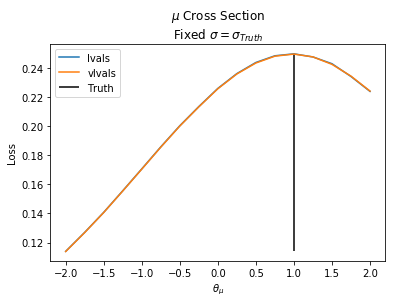

In [14]:
plt.plot(thetas, lvals, label='lvals')
plt.plot(thetas, vlvals, label='vlvals')
plt.title("$\mu$ Cross Section\nFixed $\sigma = \sigma_{Truth}$")
plt.xlabel(r'$\theta_{\mu}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[0],
           ymin=np.min(lvals),
           ymax=np.max(lvals),
           label='Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-\mu cross section.png")
plt.show()

### Cross Section for $\sigma$

In [15]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000


def my_loss_wrapper(inputs,
                    val=0.,
                    reweight_analytically=False,
                    MSE_loss=True):
    x = inputs
    x = K.gather(x, np.arange(batch_size))

    theta_prime = [theta1_param[0], val]  # fixed theta_mu = mu_truth

    if reweight_analytically:
        # analytical reweight
        weights = analytical_reweight(events=x, param=theta_prime)
    else:
        # NN (DCTR) reweight
        weights = reweight(events=x, param=theta_prime)

    def my_loss(y_true, y_pred):
        if MSE_loss:
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        else:
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))

        return K.mean(t_loss)

    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [16]:
thetas = np.linspace(0.5, 4.5, 17)
lvals = []
vlvals = []

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper(myinputs, theta),
                  metrics=['accuracy'])
    model.fit(np.array(X_train),
              y_train,
              epochs=100,
              batch_size=1000,
              validation_data=(np.array(X_test), y_test),
              verbose=1,
              callbacks=[earlystopping])
    lvals += [np.min(model.history.history['loss'])]
    vlvals += [np.min(model.history.history['val_loss'])]
    print(lvals)
    print
    pass
print(lvals)

testing theta = : 0.5
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.1755 - acc: 0.4915 - val_loss: 0.1731 - val_acc: 0.4885
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1730 - acc: 0.4873 - val_loss: 0.1734 - val_acc: 0.4922
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1730 - acc: 0.4874 - val_loss: 0.1730 - val_acc: 0.4880
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1729 - acc: 0.4876 - val_loss: 0.1733 - val_acc: 0.4879
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1729 - acc: 0.4873 - val_loss: 0.1730 - val_acc: 0.4873
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1729 - acc: 0.4878 - val_loss: 0.1730 - val_acc: 0.4883
Epoch 7/100
1000000/1000000 [==============================] - 7s 7us/step - l

Epoch 13/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2469 - acc: 0.4881 - val_loss: 0.2464 - val_acc: 0.4900
Epoch 14/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2467 - acc: 0.4885 - val_loss: 0.2477 - val_acc: 0.4968
Epoch 15/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2469 - acc: 0.4873 - val_loss: 0.2465 - val_acc: 0.4821
Epoch 16/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2468 - acc: 0.4855 - val_loss: 0.2465 - val_acc: 0.4987
Epoch 17/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2469 - acc: 0.4903 - val_loss: 0.2465 - val_acc: 0.4851
Epoch 18/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2468 - acc: 0.4914 - val_loss: 0.2465 - val_acc: 0.4859
[0.17286657012999057, 0.21162624084949494, 0.23458432760834694, 0.24673928970098497]
testing theta = : 1.5
Train on 1000000 samples, validate on 100

Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2252 - acc: 0.4849 - val_loss: 0.2239 - val_acc: 0.4987
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2247 - acc: 0.4888 - val_loss: 0.2243 - val_acc: 0.4977
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2243 - acc: 0.4880 - val_loss: 0.2242 - val_acc: 0.4917
Epoch 7/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2237 - acc: 0.4887 - val_loss: 0.2244 - val_acc: 0.5060
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2258 - acc: 0.4914 - val_loss: 0.2235 - val_acc: 0.4896
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2246 - acc: 0.4888 - val_loss: 0.2240 - val_acc: 0.4882
Epoch 10/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2240 - acc: 0.4923 - val_loss: 0.2267 - val_acc: 0.4991
Epoch 11/100

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1953 - acc: 0.4864 - val_loss: 0.1942 - val_acc: 0.4916
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1939 - acc: 0.4892 - val_loss: 0.1942 - val_acc: 0.4728
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1939 - acc: 0.4879 - val_loss: 0.1940 - val_acc: 0.4913
[0.17286657012999057, 0.21162624084949494, 0.23458432760834694, 0.24673928970098497, 0.2499499090909958, 0.24619582210481167, 0.24002713783085347, 0.2322637508660555, 0.22366215172410012, 0.21417731469869614, 0.20714900857210158, 0.20047596941888332, 0.19311883345246314]
testing theta = : 3.75
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.1915 - acc: 0.4918 - val_loss: 0.1875 - val_acc: 0.4726
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1874 - acc: 

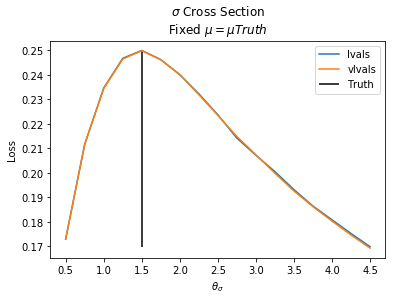

In [17]:
plt.plot(thetas, lvals, label='lvals')
plt.plot(thetas, vlvals, label='vlvals')
plt.title("$\sigma$ Cross Section\nFixed $\mu = \mu{Truth}$")
plt.xlabel(r'$\theta_{\sigma}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[1],
           ymin=np.min(lvals),
           ymax=np.max(lvals),
           label='Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-\sigma cross section.png")
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

### Building and Training Fitting Model

In [18]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(
    ". theta fit = ", model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = [0., 1.]
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(
    on_epoch_end=lambda batch, logs: fit_vals.append(model_fit.layers[-1].
                                                     get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

In [19]:
myinputs_fit = Input(shape=(1, ))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers) - 1].add_weight(
    name="thetaX",
    shape=(2, ),
    initializer=keras.initializers.Constant(value=theta_fit_init),
    trainable=True)
model_fit.summary()

batch_size = 2 * N
iterations = 50

# optimizer will be refined as fit progresses for better precision
lr_initial = 5e-1
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])


def my_loss_wrapper_fit(
        inputs,
        mysign=1,  # -1 for training theta, +1 for training g
        reweight_analytically=False,
        MSE_loss=True):
    x = inputs

    # Getting theta_prime:
    if mysign == 1:
        # regular batch size
        x = K.gather(x, np.arange(1000))
        # when not training theta, fetch as np array
        theta_prime = model_fit.layers[-1].get_weights()[0]
    else:
        # special theta batch size
        x = K.gather(x, np.arange(batch_size))
        # when training theta, fetch as tf.Variable
        theta_prime = model_fit.trainable_weights[-1]

    if reweight_analytically:
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        # NN reweight
        weights = reweight(x, theta_prime)

    def my_loss(y_true, y_pred):
        if MSE_loss:
            # Mean Squared Loss
            t_loss = mysign * (y_true * (y_true - y_pred)**2 + weights *
                               (1. - y_true) * (y_true - y_pred)**2)
        else:
            # Categorical Cross-Entropy Loss
            #Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_true) * K.log(y_pred) + weights *
                                (1 - y_true) * K.log(1 - y_pred))

        return K.mean(t_loss)

    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 2         
Total params: 16,899
Trainable params: 16,899
Non-trainable params: 0
_________________________________________________________________


In [20]:
for iteration in range(iterations):
    print("Iteration: ", iteration)
    for i in range(len(model_fit.layers) - 1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
                      loss=my_loss_wrapper_fit(myinputs_fit, 1),
                      metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train),
                  y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_data=(np.array(X_test), y_test),
                  verbose=1,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(myinputs_fit, -1),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta),
                  y_train_theta,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):, 0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):, 1]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate(
        (argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu >= iteration - index_refine[-1] - 20]

    extrema_sigma = np.concatenate(
        (argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration -
                                  index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema_mu", extrema_mu)
    print("extrema_sigma", extrema_sigma)
    '''

    if (len(extrema_mu) == 0) or (
            len(extrema_sigma)
            == 0):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >=
                                     6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10

        mean_fit = np.array([[
            np.mean(fit_vals_mu[len(fit_vals_mu) - 4:len(fit_vals_mu)]),
            np.mean(fit_vals_sigma[len(fit_vals_sigma) -
                                   4:len(fit_vals_sigma)])
        ]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2117 - acc: 0.6624 - val_loss: 0.2074 - val_acc: 0.6724
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2073 - acc: 0.6726 - val_loss: 0.2072 - val_acc: 0.6727
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2071 - acc: 0.6729 - val_loss: 0.2071 - val_acc: 0.6728
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2071 - acc: 0.6728 - val_loss: 0.2071 - val_acc: 0.6727
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2071 - acc: 0.6729 - val_loss: 0.2071 - val_acc: 0.6726
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2070 - acc: 0.6729 - val_loss: 0.2071 - val_acc: 0.6727
Epoch 7/100
1000000/1000000 [==============================] - 7s 7us/ste

Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2442 - acc: 0.5167 - val_loss: 0.2440 - val_acc: 0.4972
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2442 - acc: 0.5179 - val_loss: 0.2439 - val_acc: 0.5250
Epoch 13/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2442 - acc: 0.5190 - val_loss: 0.2439 - val_acc: 0.5130
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2442 - acc: 0.5218 - val_loss: 0.2440 - val_acc: 0.4887
Epoch 15/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2442 - acc: 0.5169 - val_loss: 0.2442 - val_acc: 0.5404
Epoch 16/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2441 - acc: 0.5196 - val_loss: 0.2439 - val_acc: 0.5027
Epoch 17/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2441 - acc: 0.5193 - val_loss: 0.2439 - val_acc: 0.5333
Epoch 

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2437 - acc: 0.5243 - val_loss: 0.2436 - val_acc: 0.5075
Epoch 69/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2436 - acc: 0.5209 - val_loss: 0.2437 - val_acc: 0.5230
Epoch 70/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2435 - acc: 0.5218 - val_loss: 0.2436 - val_acc: 0.5363
Epoch 71/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2436 - acc: 0.5263 - val_loss: 0.2438 - val_acc: 0.5239
Epoch 72/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2438 - acc: 0.5236 - val_loss: 0.2437 - val_acc: 0.5250
Epoch 73/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2435 - acc: 0.5279 - val_loss: 0.2436 - val_acc: 0.5217
Epoch 74/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2436 - acc: 0.5235 - val_loss: 0.2437 - val_acc: 0.5152
Epoch 75/100
100000

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.3508 - val_loss: 0.2485 - val_acc: 0.3390
Epoch 37/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.3473 - val_loss: 0.2492 - val_acc: 0.3579
Epoch 38/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.3496 - val_loss: 0.2494 - val_acc: 0.3621
Epoch 39/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2486 - acc: 0.3504 - val_loss: 0.2485 - val_acc: 0.3484
Epoch 40/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.3498 - val_loss: 0.2485 - val_acc: 0.3491
Epoch 41/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.3492 - val_loss: 0.2487 - val_acc: 0.3471
Epoch 42/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2482 - acc: 0.3496 - val_loss: 0.2488 - val_acc: 0.3468
Training theta
Epoc

Epoch 17/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2472 - acc: 0.5351 - val_loss: 0.2470 - val_acc: 0.5301
Epoch 18/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2472 - acc: 0.5351 - val_loss: 0.2470 - val_acc: 0.5454
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 9s 5us/step - loss: -0.2471 - acc: 0.5346
. theta fit =  [1.1651871 1.5268962]
Iteration:  7
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 13s 13us/step - loss: 0.2507 - acc: 0.3899 - val_loss: 0.2492 - val_acc: 0.3391
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2491 - acc: 0.3380 - val_loss: 0.2489 - val_acc: 0.3376
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2489 - acc: 0.3405 - val_loss: 0.2488 - val_acc: 0.3429
Epoch 4/100
1000000/1000000 [============================

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2497 - acc: 0.4278 - val_loss: 0.2495 - val_acc: 0.4286
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2496 - acc: 0.4269 - val_loss: 0.2498 - val_acc: 0.4324
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2495 - acc: 0.4375 - val_loss: 0.2495 - val_acc: 0.4279
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2495 - acc: 0.4312 - val_loss: 0.2495 - val_acc: 0.4237
Epoch 8/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2496 - acc: 0.4342 - val_loss: 0.2495 - val_acc: 0.4307
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2497 - acc: 0.4296 - val_loss: 0.2495 - val_acc: 0.4498
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2495 - acc: 0.4427 - val_loss: 0.2495 - val_acc: 0.4305
Epoch 11/100
1000000/100

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.4635 - val_loss: 0.2500 - val_acc: 0.4586
Epoch 35/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2497 - acc: 0.4526 - val_loss: 0.2497 - val_acc: 0.4243
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 10s 5us/step - loss: -0.2497 - acc: 0.4413
. theta fit =  [0.99078804 1.4491132 ]
Iteration:  11
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 13s 13us/step - loss: 0.2503 - acc: 0.4655 - val_loss: 0.2499 - val_acc: 0.4835
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.4701 - val_loss: 0.2499 - val_acc: 0.4516
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2498 - acc: 0.4815 - val_loss: 0.2498 - val_acc: 0.4331
Epoch 4/100
1000000/1000000 [==============================] - 8s 

Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.4818 - val_loss: 0.2500 - val_acc: 0.4955
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2498 - acc: 0.4854 - val_loss: 0.2505 - val_acc: 0.4532
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.4719 - val_loss: 0.2505 - val_acc: 0.4471
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.4798 - val_loss: 0.2499 - val_acc: 0.4568
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.4744 - val_loss: 0.2501 - val_acc: 0.4874
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.4871 - val_loss: 0.2498 - val_acc: 0.4750
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.4883 - val_loss: 0.2500 - val_acc: 0.4874
Epoch 12/10

1000000/1000000 [==============================] - 14s 14us/step - loss: 0.2503 - acc: 0.4831 - val_loss: 0.2500 - val_acc: 0.4537
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.4590 - val_loss: 0.2500 - val_acc: 0.4789
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.4767 - val_loss: 0.2498 - val_acc: 0.5023
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.4949 - val_loss: 0.2498 - val_acc: 0.4740
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.4803 - val_loss: 0.2499 - val_acc: 0.4705
Epoch 6/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.4694 - val_loss: 0.2506 - val_acc: 0.4987
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.4774 - val_loss: 0.2503 - val_acc: 0.4676
Epoch 8/100
1000000/100

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.4842 - val_loss: 0.2502 - val_acc: 0.4900
Epoch 17/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.4762 - val_loss: 0.2507 - val_acc: 0.4745
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 11s 6us/step - loss: -0.2498 - acc: 0.4713
. theta fit =  [0.96526754 1.4723394 ]
====Refining Learning Rate====
Iteration:  18
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.2503 - acc: 0.4728 - val_loss: 0.2498 - val_acc: 0.4784
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.4839 - val_loss: 0.2506 - val_acc: 0.5046
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.5032 - val_loss: 0.2507 - val_acc: 0.4834
Epoch 4/100
1000000/1000000 [======

Epoch 17/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2501 - acc: 0.5007 - val_loss: 0.2500 - val_acc: 0.4921
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.2498 - acc: 0.5113
. theta fit =  [0.97272843 1.4549849 ]
Iteration:  20
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 15s 15us/step - loss: 0.2500 - acc: 0.5030 - val_loss: 0.2504 - val_acc: 0.5097
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5166 - val_loss: 0.2502 - val_acc: 0.5053
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.4991 - val_loss: 0.2498 - val_acc: 0.5102
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5061 - val_loss: 0.2502 - val_acc: 0.5212
Epoch 5/100
1000000/1000000 [=========================

Epoch 16/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5184 - val_loss: 0.2499 - val_acc: 0.5085
Epoch 17/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5148 - val_loss: 0.2498 - val_acc: 0.5287
Epoch 18/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5229 - val_loss: 0.2498 - val_acc: 0.5240
Epoch 19/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5197 - val_loss: 0.2498 - val_acc: 0.5243
Epoch 20/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.5190 - val_loss: 0.2498 - val_acc: 0.5239
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.2498 - acc: 0.5132
. theta fit =  [0.965537  1.4525968]
Iteration:  23
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [=========================

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5343 - val_loss: 0.2500 - val_acc: 0.5241
Epoch 8/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5286 - val_loss: 0.2502 - val_acc: 0.5252
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.5279 - val_loss: 0.2501 - val_acc: 0.5249
Epoch 10/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2497 - acc: 0.5269 - val_loss: 0.2499 - val_acc: 0.5230
Epoch 11/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.5260 - val_loss: 0.2507 - val_acc: 0.5260
Epoch 12/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5323 - val_loss: 0.2504 - val_acc: 0.5244
Epoch 13/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.5287 - val_loss: 0.2497 - val_acc: 0.5076
Epoch 14/100
100000

1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2499 - acc: 0.5099 - val_loss: 0.2499 - val_acc: 0.5481
Epoch 13/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2498 - acc: 0.5276 - val_loss: 0.2500 - val_acc: 0.5132
Epoch 14/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2500 - acc: 0.5170 - val_loss: 0.2497 - val_acc: 0.5201
Epoch 15/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5230 - val_loss: 0.2498 - val_acc: 0.5196
Epoch 16/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5200 - val_loss: 0.2500 - val_acc: 0.5089
Epoch 17/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2499 - acc: 0.5177 - val_loss: 0.2498 - val_acc: 0.5022
Epoch 18/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.5114 - val_loss: 0.2510 - val_acc: 0.5073
Epoch 19/10

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2499 - acc: 0.5176 - val_loss: 0.2498 - val_acc: 0.5311
Epoch 12/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2500 - acc: 0.5209 - val_loss: 0.2509 - val_acc: 0.5386
Epoch 13/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2498 - acc: 0.5252 - val_loss: 0.2502 - val_acc: 0.5276
Epoch 14/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2496 - acc: 0.5127 - val_loss: 0.2497 - val_acc: 0.5157
Epoch 15/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5133 - val_loss: 0.2502 - val_acc: 0.5226
Epoch 16/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2499 - acc: 0.5192 - val_loss: 0.2501 - val_acc: 0.5186
Epoch 17/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2498 - acc: 0.5172 - val_loss: 0.2498 - val_acc: 0.5139
Epoch 18/

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2500 - acc: 0.5346 - val_loss: 0.2503 - val_acc: 0.5045
Epoch 13/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2500 - acc: 0.5119 - val_loss: 0.2501 - val_acc: 0.5294
Epoch 14/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.5263 - val_loss: 0.2508 - val_acc: 0.5328
Epoch 15/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2498 - acc: 0.5233 - val_loss: 0.2503 - val_acc: 0.5303
Epoch 16/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5248 - val_loss: 0.2506 - val_acc: 0.5170
Epoch 17/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5301 - val_loss: 0.2502 - val_acc: 0.5300
Epoch 18/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.5244 - val_loss: 0.2506 - val_acc: 0.5296
Epoch 19/100


1000000/1000000 [==============================] - 17s 17us/step - loss: 0.2500 - acc: 0.5103 - val_loss: 0.2497 - val_acc: 0.4960
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.5173 - val_loss: 0.2497 - val_acc: 0.5165
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2496 - acc: 0.5167 - val_loss: 0.2510 - val_acc: 0.5397
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2500 - acc: 0.5158 - val_loss: 0.2498 - val_acc: 0.5320
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2497 - acc: 0.5159 - val_loss: 0.2500 - val_acc: 0.5205
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.5141 - val_loss: 0.2500 - val_acc: 0.5302
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5157 - val_loss: 0.2498 - val_acc: 0.4963
Epoch 8/100
1000000/100

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.5245 - val_loss: 0.2498 - val_acc: 0.5247
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 13s 6us/step - loss: -0.2497 - acc: 0.5272
. theta fit =  [0.96439624 1.4528636 ]
Iteration:  39
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 17s 17us/step - loss: 0.2507 - acc: 0.5190 - val_loss: 0.2513 - val_acc: 0.5150
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2501 - acc: 0.5110 - val_loss: 0.2508 - val_acc: 0.5330
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2500 - acc: 0.5069 - val_loss: 0.2498 - val_acc: 0.5365
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2497 - acc: 0.5290 - val_loss: 0.2507 - val_acc: 0.5318
Epoch 5/100
1000000/1000000 [==============================] - 9s 9

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.5247 - val_loss: 0.2497 - val_acc: 0.5107
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5223 - val_loss: 0.2500 - val_acc: 0.5332
Epoch 8/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.5275 - val_loss: 0.2497 - val_acc: 0.5154
Epoch 9/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5255 - val_loss: 0.2497 - val_acc: 0.5145
Epoch 10/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2495 - acc: 0.5105 - val_loss: 0.2513 - val_acc: 0.5643
Epoch 11/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5259 - val_loss: 0.2500 - val_acc: 0.5151
Epoch 12/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.5275 - val_loss: 0.2503 - val_acc: 0.4978
Epoch 13/100
1000000/1

Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2503 - acc: 0.5191 - val_loss: 0.2502 - val_acc: 0.5104
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5278 - val_loss: 0.2499 - val_acc: 0.4925
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5149 - val_loss: 0.2503 - val_acc: 0.5483
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.5303 - val_loss: 0.2499 - val_acc: 0.5060
Epoch 6/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5177 - val_loss: 0.2497 - val_acc: 0.5343
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.5340 - val_loss: 0.2497 - val_acc: 0.5292
Epoch 8/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.5253 - val_loss: 0.2497 - val_acc: 0.4996
Epoch 9/100
1

Epoch 13/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5121 - val_loss: 0.2502 - val_acc: 0.5025
Epoch 14/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.5265 - val_loss: 0.2508 - val_acc: 0.5133
Epoch 15/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.5063 - val_loss: 0.2497 - val_acc: 0.5367
Epoch 16/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.5231 - val_loss: 0.2500 - val_acc: 0.5035
Epoch 17/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5140 - val_loss: 0.2497 - val_acc: 0.5296
Epoch 18/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5211 - val_loss: 0.2498 - val_acc: 0.4987
Epoch 19/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2499 - acc: 0.5180 - val_loss: 0.2498 - val_acc: 0.5087
Epoch 

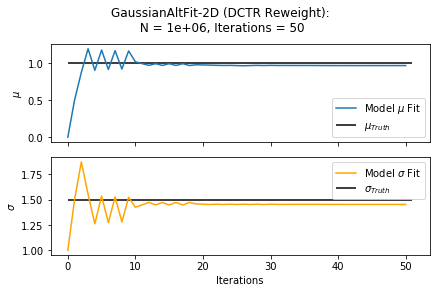

In [21]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "GaussianAltFit-2D (DCTR Reweight):\n N = {:.0e}, Iterations = {:.0f}".
    format(N, iterations))
axs[0].plot(fit_vals[:, 0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(fit_vals[:, 1], label='Model $\sigma$ Fit', color='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D (DCTR Reweight):\n N = {:.0e}, Iterations = {:.0f}.png".
#     format(N, iterations))
plt.show()

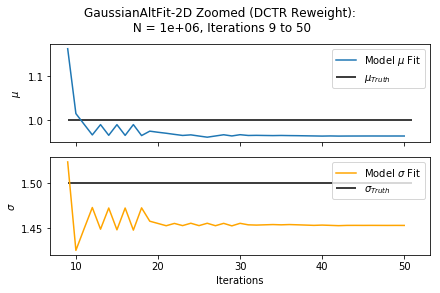

In [22]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "GaussianAltFit-2D Zoomed (DCTR Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:, 0])),
            fit_vals[index_refine[1]:, 0],
            label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0],
              index_refine[1],
              len(fit_vals),
              label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:, 1])),
            fit_vals[index_refine[1]:, 1],
            label='Model $\sigma$ Fit',
            color='orange')
axs[1].hlines(theta1_param[1],
              index_refine[1],
              len(fit_vals),
              label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D Zoomed (DCTR Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png"
#     .format(N, index_refine[1], iterations))
plt.show()

#### Compare Fitting between DCTR Reweighting and Analytical Reweighting

In [23]:
fit_vals = [theta_fit_init]
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [24]:
for iteration in range(iterations):
    print("Iteration: ", iteration)
    for i in range(len(model_fit.layers) - 1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
                      loss=my_loss_wrapper_fit(myinputs_fit,
                                               1,
                                               reweight_analytically=True),
                      metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train),
                  y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_data=(np.array(X_test), y_test),
                  verbose=1,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(myinputs_fit,
                                               -1,
                                               reweight_analytically=True),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta),
                  y_train_theta,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):, 0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):, 1]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate(
        (argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu >= iteration - index_refine[-1] - 20]

    extrema_sigma = np.concatenate(
        (argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration -
                                  index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema_mu", extrema_mu)
    print("extrema_sigma", extrema_sigma)
    '''

    if (len(extrema_mu) == 0) or (
            len(extrema_sigma)
            == 0):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >=
                                     6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10

        mean_fit = np.array([[
            np.mean(fit_vals_mu[len(fit_vals_mu) - 4:len(fit_vals_mu)]),
            np.mean(fit_vals_sigma[len(fit_vals_sigma) -
                                   4:len(fit_vals_sigma)])
        ]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 19s 19us/step - loss: 0.2500 - acc: 0.5456 - val_loss: 0.2495 - val_acc: 0.5881
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5591 - val_loss: 0.2488 - val_acc: 0.6072
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5808 - val_loss: 0.2489 - val_acc: 0.5609
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2484 - acc: 0.5636 - val_loss: 0.2489 - val_acc: 0.5893
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5682 - val_loss: 0.2495 - val_acc: 0.5654
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5830 - val_loss: 0.2492 - val_acc: 0.5686
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/ste

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2367 - acc: 0.4115 - val_loss: 0.2403 - val_acc: 0.4194
Epoch 25/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2368 - acc: 0.4128 - val_loss: 0.2420 - val_acc: 0.4202
Epoch 26/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2364 - acc: 0.4136 - val_loss: 0.2432 - val_acc: 0.4308
Epoch 27/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2363 - acc: 0.4153 - val_loss: 0.2397 - val_acc: 0.4110
Epoch 28/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2368 - acc: 0.4132 - val_loss: 0.2361 - val_acc: 0.4142
Epoch 29/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2360 - acc: 0.4156 - val_loss: 0.2359 - val_acc: 0.4190
Epoch 30/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2376 - acc: 0.4160 - val_loss: 0.2358 - val_acc: 0.4165
Epoch 31/100
100000

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2447 - acc: 0.6179 - val_loss: 0.2445 - val_acc: 0.6216
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2446 - acc: 0.6187 - val_loss: 0.2445 - val_acc: 0.6273
Epoch 13/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2447 - acc: 0.6184 - val_loss: 0.2445 - val_acc: 0.6165
Epoch 14/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2446 - acc: 0.6170 - val_loss: 0.2446 - val_acc: 0.6117
Epoch 15/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2447 - acc: 0.6170 - val_loss: 0.2445 - val_acc: 0.6184
Epoch 16/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2446 - acc: 0.6177 - val_loss: 0.2446 - val_acc: 0.6191
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.2445 - acc: 0.6144
. theta fit =  [1.0576555 1.5497549]
Itera

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2454 - acc: 0.6204 - val_loss: 0.2452 - val_acc: 0.6160
Epoch 26/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2452 - acc: 0.6191 - val_loss: 0.2454 - val_acc: 0.6243
Epoch 27/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2453 - acc: 0.6210 - val_loss: 0.2454 - val_acc: 0.6098
Epoch 28/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2454 - acc: 0.6187 - val_loss: 0.2453 - val_acc: 0.6288
Epoch 29/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2453 - acc: 0.6203 - val_loss: 0.2453 - val_acc: 0.6126
Epoch 30/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2454 - acc: 0.6207 - val_loss: 0.2452 - val_acc: 0.6177
Epoch 31/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2453 - acc: 0.6193 - val_loss: 0.2453 - val_acc: 0.6250
Epoch 32/100
100000

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2458 - acc: 0.6155 - val_loss: 0.2457 - val_acc: 0.6196
Epoch 20/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2458 - acc: 0.6141 - val_loss: 0.2457 - val_acc: 0.6131
Epoch 21/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2458 - acc: 0.6146 - val_loss: 0.2458 - val_acc: 0.6110
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.2457 - acc: 0.6157
. theta fit =  [1.0461992 1.5381924]
====Refining Learning Rate====
Iteration:  8
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 18s 18us/step - loss: 0.2491 - acc: 0.5910 - val_loss: 0.2494 - val_acc: 0.5912
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5880 - val_loss: 0.2484 - val_acc: 0.5746
Epoch 3/100
1000000/1000000 [========

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.6356 - val_loss: 0.2487 - val_acc: 0.6512
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.6364 - val_loss: 0.2486 - val_acc: 0.6006
Epoch 15/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.6244 - val_loss: 0.2496 - val_acc: 0.6463
Epoch 16/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.6406 - val_loss: 0.2492 - val_acc: 0.6457
Epoch 17/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.6436 - val_loss: 0.2484 - val_acc: 0.6177
Epoch 18/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.6366 - val_loss: 0.2487 - val_acc: 0.6346
Epoch 19/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.6364 - val_loss: 0.2492 - val_acc: 0.6615
Epoch 20/100
100000

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5673 - val_loss: 0.2493 - val_acc: 0.4950
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5776 - val_loss: 0.2492 - val_acc: 0.6095
Epoch 13/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2489 - acc: 0.5815 - val_loss: 0.2488 - val_acc: 0.5825
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5794 - val_loss: 0.2486 - val_acc: 0.6194
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.2484 - acc: 0.5876
. theta fit =  [0.9434349 1.4355587]
Iteration:  13
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 19s 19us/step - loss: 0.2504 - acc: 0.6016 - val_loss: 0.2500 - val_acc: 0.5815
Epoch 2/100
1000000/1000000 [==============================] - 8s 

Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 18s 18us/step - loss: 0.2491 - acc: 0.5762 - val_loss: 0.2492 - val_acc: 0.6021
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5815 - val_loss: 0.2487 - val_acc: 0.4938
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5698 - val_loss: 0.2489 - val_acc: 0.6184
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5742 - val_loss: 0.2494 - val_acc: 0.5889
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5821 - val_loss: 0.2492 - val_acc: 0.5890
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2489 - acc: 0.5631 - val_loss: 0.2485 - val_acc: 0.6532
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.24

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2491 - acc: 0.5909 - val_loss: 0.2492 - val_acc: 0.5540
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2486 - acc: 0.5874 - val_loss: 0.2498 - val_acc: 0.6453
Epoch 12/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2488 - acc: 0.5983 - val_loss: 0.2491 - val_acc: 0.6466
Epoch 13/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2486 - acc: 0.5955 - val_loss: 0.2485 - val_acc: 0.6257
Epoch 14/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2484 - acc: 0.5992 - val_loss: 0.2495 - val_acc: 0.5613
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.2485 - acc: 0.5615
. theta fit =  [0.942594  1.4380469]
====Refining Learning Rate====
Iteration:  19
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [=======

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2491 - acc: 0.5737 - val_loss: 0.2487 - val_acc: 0.6196
Epoch 16/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5897 - val_loss: 0.2486 - val_acc: 0.5695
Epoch 17/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5973 - val_loss: 0.2492 - val_acc: 0.5800
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 13s 6us/step - loss: -0.2485 - acc: 0.6273
. theta fit =  [0.9577476 1.4565885]
Iteration:  22
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 18s 18us/step - loss: 0.2495 - acc: 0.5969 - val_loss: 0.2499 - val_acc: 0.5857
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2489 - acc: 0.6001 - val_loss: 0.2495 - val_acc: 0.5008
Epoch 3/100
1000000/1000000 [==============================] - 8s 8

Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5873 - val_loss: 0.2495 - val_acc: 0.5583
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5753 - val_loss: 0.2484 - val_acc: 0.6481
Epoch 13/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.6026 - val_loss: 0.2485 - val_acc: 0.5254
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5945 - val_loss: 0.2488 - val_acc: 0.5286
Epoch 15/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5884 - val_loss: 0.2485 - val_acc: 0.5901
Epoch 16/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5974 - val_loss: 0.2486 - val_acc: 0.4990
Epoch 17/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2484 - acc: 0.5873 - val_loss: 0.2499 - val_acc: 0.6485
Epoch 

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5791 - val_loss: 0.2494 - val_acc: 0.6500
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2489 - acc: 0.5988 - val_loss: 0.2492 - val_acc: 0.6553
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2484 - acc: 0.6006 - val_loss: 0.2503 - val_acc: 0.6334
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2492 - acc: 0.5923 - val_loss: 0.2485 - val_acc: 0.6521
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5952 - val_loss: 0.2483 - val_acc: 0.6149
Epoch 13/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2484 - acc: 0.5836 - val_loss: 0.2506 - val_acc: 0.6520
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2490 - acc: 0.5934 - val_loss: 0.2500 - val_acc: 0.6174
Epoch 15/100
1000000

Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5843 - val_loss: 0.2484 - val_acc: 0.6347
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.6001 - val_loss: 0.2486 - val_acc: 0.5611
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5769 - val_loss: 0.2485 - val_acc: 0.6519
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5976 - val_loss: 0.2485 - val_acc: 0.6070
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5893 - val_loss: 0.2485 - val_acc: 0.5884
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5913 - val_loss: 0.2493 - val_acc: 0.6207
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5747 - val_loss: 0.2492 - val_acc: 0.6202
Epoch 10/100


1000000/1000000 [==============================] - 20s 20us/step - loss: 0.2497 - acc: 0.5887 - val_loss: 0.2501 - val_acc: 0.6179
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5726 - val_loss: 0.2487 - val_acc: 0.6173
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5861 - val_loss: 0.2485 - val_acc: 0.5002
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5861 - val_loss: 0.2490 - val_acc: 0.5844
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5845 - val_loss: 0.2484 - val_acc: 0.6351
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2483 - acc: 0.5886 - val_loss: 0.2501 - val_acc: 0.6256
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2490 - acc: 0.5926 - val_loss: 0.2499 - val_acc: 0.6524
Epoch 8/100
1000000/100

1000000/1000000 [==============================] - 21s 21us/step - loss: 0.2508 - acc: 0.5755 - val_loss: 0.2503 - val_acc: 0.5443
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5721 - val_loss: 0.2503 - val_acc: 0.6244
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2491 - acc: 0.5817 - val_loss: 0.2494 - val_acc: 0.5819
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5732 - val_loss: 0.2488 - val_acc: 0.6288
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5984 - val_loss: 0.2485 - val_acc: 0.5314
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5942 - val_loss: 0.2497 - val_acc: 0.5812
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5801 - val_loss: 0.2484 - val_acc: 0.6521
Epoch 8/100
1000000/100

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2489 - acc: 0.5776 - val_loss: 0.2487 - val_acc: 0.4960
Epoch 19/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5849 - val_loss: 0.2484 - val_acc: 0.4966
Epoch 20/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5922 - val_loss: 0.2498 - val_acc: 0.6139
Epoch 21/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5860 - val_loss: 0.2489 - val_acc: 0.6407
Epoch 22/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2484 - acc: 0.6041 - val_loss: 0.2499 - val_acc: 0.5822
Epoch 23/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5928 - val_loss: 0.2495 - val_acc: 0.5743
Epoch 24/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5885 - val_loss: 0.2490 - val_acc: 0.5812
Training theta
Epoc

Epoch 19/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5871 - val_loss: 0.2495 - val_acc: 0.5883
Epoch 20/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5936 - val_loss: 0.2489 - val_acc: 0.5795
Epoch 21/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5865 - val_loss: 0.2485 - val_acc: 0.5580
Epoch 22/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.6010 - val_loss: 0.2487 - val_acc: 0.5822
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 15s 8us/step - loss: -0.2485 - acc: 0.6386
. theta fit =  [0.96543485 1.4546496 ]
Iteration:  39
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 22s 22us/step - loss: 0.2499 - acc: 0.5845 - val_loss: 0.2504 - val_acc: 0.5474
Epoch 2/100
1000000/1000000 [======================

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2484 - acc: 0.5805 - val_loss: 0.2484 - val_acc: 0.5050
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.2484 - acc: 0.6059
. theta fit =  [0.96481943 1.4552857 ]
Iteration:  41
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 21s 21us/step - loss: 0.2499 - acc: 0.5627 - val_loss: 0.2504 - val_acc: 0.6341
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5843 - val_loss: 0.2487 - val_acc: 0.5027
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5630 - val_loss: 0.2500 - val_acc: 0.5801
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5635 - val_loss: 0.2501 - val_acc: 0.5712
Epoch 5/100
1000000/1000000 [==============================] - 8s 8

Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2484 - acc: 0.5841 - val_loss: 0.2500 - val_acc: 0.6111
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5705 - val_loss: 0.2485 - val_acc: 0.5423
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2490 - acc: 0.5916 - val_loss: 0.2491 - val_acc: 0.5404
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5741 - val_loss: 0.2497 - val_acc: 0.6394
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.5941 - val_loss: 0.2490 - val_acc: 0.5256
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5940 - val_loss: 0.2491 - val_acc: 0.5077
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5749 - val_loss: 0.2497 - val_acc: 0.5937
Epoch 13/1

Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5938 - val_loss: 0.2485 - val_acc: 0.5568
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.6019 - val_loss: 0.2485 - val_acc: 0.6211
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.6026 - val_loss: 0.2487 - val_acc: 0.5690
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2485 - acc: 0.5864 - val_loss: 0.2498 - val_acc: 0.6548
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5942 - val_loss: 0.2486 - val_acc: 0.4914
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2484 - acc: 0.5862 - val_loss: 0.2495 - val_acc: 0.6274
Epoch 11/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2488 - acc: 0.5898 - val_loss: 0.2485 - val_acc: 0.5328
Epoch 12/10

Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5820 - val_loss: 0.2487 - val_acc: 0.5711
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5726 - val_loss: 0.2488 - val_acc: 0.6094
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5796 - val_loss: 0.2486 - val_acc: 0.6427
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2484 - acc: 0.5915 - val_loss: 0.2501 - val_acc: 0.6171
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2487 - acc: 0.5960 - val_loss: 0.2490 - val_acc: 0.6086
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2488 - acc: 0.6148 - val_loss: 0.2486 - val_acc: 0.5943
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2486 - acc: 0.5954 - val_loss: 0.2484 - val_acc: 0.5556
Epoch 13/1

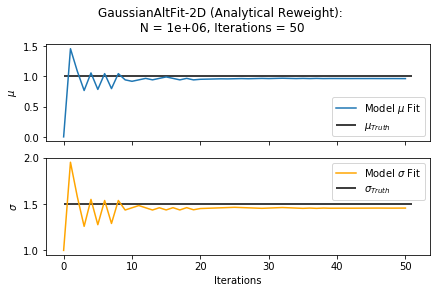

In [25]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "GaussianAltFit-2D (Analytical Reweight):\n N = {:.0e}, Iterations = {:.0f}"
    .format(N, iterations))
axs[0].plot(fit_vals[:, 0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(fit_vals[:, 1], label='Model $\sigma$ Fit', color='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D (Analytical Reweight):\n N = {:.0e}, Iterations = {:.0f}.png"
#     .format(N, iterations))
plt.show()

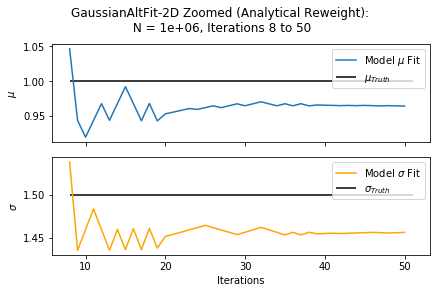

In [26]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "GaussianAltFit-2D Zoomed (Analytical Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:, 0])),
            fit_vals[index_refine[1]:, 0],
            label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0],
              index_refine[1],
              len(fit_vals),
              label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:, 1])),
            fit_vals[index_refine[1]:, 1],
            label='Model $\sigma$ Fit',
            color='orange')
axs[1].hlines(theta1_param[1],
              index_refine[1],
              len(fit_vals),
              label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D Zoomed (Analytical Reweight):\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png"
#     .format(N, index_refine[1], iterations))
plt.show()